### Project Number 2 Submission - Investigate a Dataset - Titanic

![Titanic](titanic.png "Titanic")

>  

**SUBMISSION AGENDA for the Question: **  - **"What factors made people more likely to survive?"**


**(A) Initial Dataset Interrogation** - A cursory investigation of what is known about the dataset and it's contents.


**(B) Direction of Inquiry** - An overview of the facts generally known about the event, it's relevant history and the culture of the time period, a perusal of publicly available data gathered in the wake of the tragedy, and an attempt to make a case for the initial (and subsequent) line(s) of inquiry one might make of the dataset.


**(C) Data Analysis and Discovery:** 
1. Perform exploratory analysis on dataset to get acquainted with the data 
2. Establish major contributing factors governing survival rates 
3. Construct basic heuristics to predict survival rates and a methodology to assess it's accuracy 
4. Incorporate machine learning to verify findings, enhance accuracy, and suggest additional causal factors
5. Illuminate the necessary dataset transformations required for advanced feature modeling 
6. Engage in feature engineering to further uncover key contributory features
7. Construct an advanced heuristic to better predict survival rates


**(D) FINDINGS / CONCLUSIONS REPORT** - A summary of the findings are presented along with inferences and supporting data.

**(E) LIMITATIONS and SHORTCOMINGS** -  A summary the limitations and shortcomings regardings the results and the methods being used.

**(F) REFERENCES**


>  


** SETUP**

In [42]:
# Setup the various IMPORT statements for required libraries

import csv
import re
import operator
import warnings
import numpy as np
import pandas as pd
import pandasql
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from __future__ import division  # forces "/ "to adopt Python 3.x's behavior that always returns a float.

# Ignore Deprecation Warnings 
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Inline Graphics for IPython NB's
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/chamling/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**OVERVIEW OF THE DATASET: ** 

> This is a quick perusal of the datset to understand it's structure, features distribution, missing values (and how they are handled), and general information about the data itself.

In [2]:
# Read in the Titanic Dataset into a Pandas DataFrame
filename = 'titanic_data.csv'
titanic_df = pd.read_csv(filename)

In [3]:
# Execute a cursory examination of the data by listing the first 10 lines of the dataframe.
titanic_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
# Quick glance at the structure of the data. 
# It is obvious that there exists some missing data for Age (714) and Cabin (204). 
# Age is important so the NAN's will be substituted with the Median Age.
# Cabin can safely be ignored since it's not used in the analysis.

# NOTE: Later during the Machine Learning Phase, the variable AGE will need to be handled
#       appropriately along with SEX and EMBARKED (which will need to be transformed into 
#       numerical values rather than strings).

titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**(A) INITIAL DATASET INTERROGATION**

> A cursory investigation of what is known about the dataset and it's structure.

Each **row** (of the 891 total records) represents a single passenger on the titanic:

* PassengerId -- A numerical id assigned to each passenger.
* Survived -- Whether the passenger survived (1), or perished (0).
* Pclass -- The class the passenger was in -- first class (1), second class (2), or third class (3).
* Name -- the name of the passenger.
* Sex -- The gender of the passenger -- male or female.
* Age -- The age of the passenger.
* SibSp -- The number of siblings and spouses the passenger had on board.
* Parch -- The number of parents and children the passenger had on board.
* Ticket -- The ticket number of the passenger.
* Fare -- How much the passenger paid for the ticker.
* Cabin -- Which cabin the passenger was in.
* Embarked -- Port of Embarkation: (C = Cherbourg; Q = Queenstown; S = Southampton)

**Special Notes:**
Pclass is a proxy for **socio-economic status** (SES): 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

> With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

* Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
* Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
* Parent:   Mother or Father of Passenger Aboard Titanic
* Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic


* Source: https://www.kaggle.com/c/titanic/data

>  


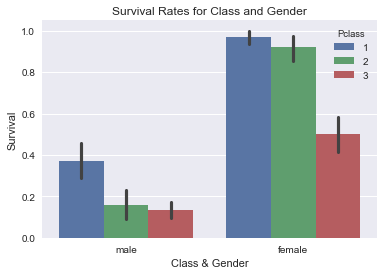

In [5]:
# Survival Rates via Gender and Class 
# This shows that women survived most, as well as those in 1st and 2nd class.

pclass_plt = sns.barplot(x="Sex", y="Survived", hue="Pclass", data=titanic_df)
pclass_plt.set_title('Survival Rates for Class and Gender')
pclass_plt.set_ylabel('Survival')
pclass_plt.set_xlabel('Class & Gender')

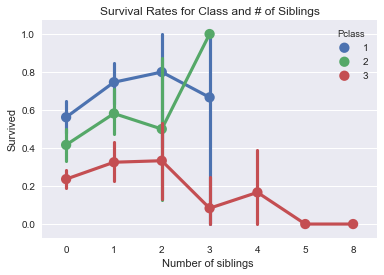

In [6]:
# Survival Rates via Siblings and Class 
#
# This is interesting in that larger families tended to perished whole,
# while those with only one child (perhaps to carry the family name) 
# or infant was favored.

sib_survived_plt = sns.pointplot(x="SibSp", y="Survived", hue="Pclass", data=titanic_df)
sib_survived_plt.set_title('Survival Rates for Class and # of Siblings')
sib_survived_plt.set_ylabel('Survived')
sib_survived_plt.set_xlabel('Number of siblings ')

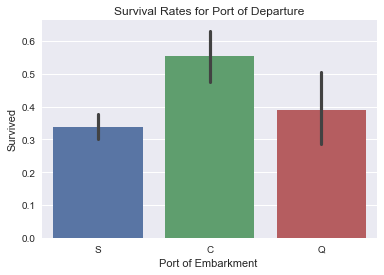

In [7]:
# Survival Rates via port of departure
#
# The data suggests that "C" - Embarked at Cherbourg stood a higher chance of survival.

embarked_plt = sns.barplot(x="Embarked", y="Survived", data=titanic_df)
embarked_plt.set_title('Survival Rates for Port of Departure')
embarked_plt.set_ylabel('Survived')
embarked_plt.set_xlabel('Port of Embarkment ')

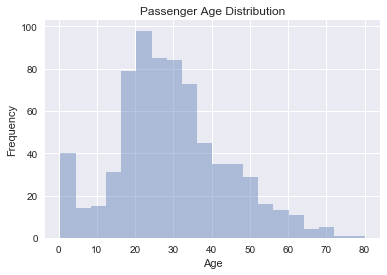

In [8]:
# PASSENGER AGE
# Standard Normal Distribution of a quantative variable with a Large Mean and a few outliers.

# Data Transformation - Drop the NAN's 
age_no_nans = titanic_df["Age"].dropna()

age_plt = sns.distplot(age_no_nans, kde=False)
age_plt.set_title('Passenger Age Distribution')
age_plt.set_ylabel('Frequency')
age_plt.set_xlabel('Age')

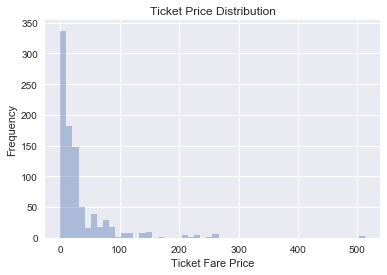

In [9]:
# TICKET PRICE: Fare
# The majority of the tickets were of the cheaper variety (likely 3rd Class)
# There were far less of the "more" expensive tickets: (1st and 2nd Class)

fare_plt = sns.distplot(titanic_df.Fare, kde=False)
fare_plt.set_title('Ticket Price Distribution')
fare_plt.set_ylabel('Frequency')
fare_plt.set_xlabel('Ticket Fare Price')

In [10]:
# VERIFICATION: Confirm the record count in the Dataset is actually 891.
len(titanic_df)

891

**(B) DIRECTION OF INQUIRY - The Question(s) to be Answered. **

> An overview of the facts generally known about the event, it's history and the culture of the time period, a perusal of publically available data gathered in the wake of the tragedy, and an attempt to make a case for the initial (and subsequent) line(s) of inquiry that might make of the dataset.


**Generally Available Information** - to establish **general trends** and avenues of inquiry only, *not* necessarily specific to the dataset to be interrogated:

* **Fewer than a third** of those aboard Titanic **survived** the disaster.
* Titanic's passengers numbered **roughly** around 1,317 people: 324 in **First Class**, 284 in **Second Class**, and 709 in **Third Class**. 
* Of these, 869 (66%) were **male** and 447 (34%) **female**. There were 107 **children** aboard, the **largest number** of which were in **Third Class**.
* The ship was considerably **under capacity** on her maiden voyage, as she **could** accommodate 2,566 passengers—1,034 First Class, 510 Second Class, and **1,022** in Third Class.


* Source: https://en.wikipedia.org/wiki/RMS_Titanic


> 

**Dataset Specific Information** - pertaining to **this** analysis specifically:


* The dataset examined in this study is considerably **smaller** and only contains passenger information from a total of ** 891** of the total number of passengers on board the Titanic.

> 

**Event History and Time Period Cultural Considerations:** 

> The time period of the event was the early 1900's, specifically **1912**. That was a time where **Chivalry** was very much alive and well as evidenced by the account of the **ships eight-member band**, led by Wallace Hartley. They had assembled in the first-class lounge in an effort to **keep passengers calm and upbeat**. Later they moved on to the forward half of the boat deck. The band continued playing, even when it became apparent the ship was going to sink, and that all members would perish.

* Source: https://en.wikipedia.org/wiki/Legends_and_myths_regarding_RMS_Titanic

> To emphasize the gravity of the cultural imperative of **Chivalry** prevalent during that that time period, it is useful to contrast that event against a more recent example of **Cowardice** in a similar event, namely **The Costa Concordia** where the disgraced ships captain Francesco Schettino (discovered to be chiefly responsible for the disaster), fled in a lifeboat while there were **still** passengers attempting to escape the doomed ship.

* Source(s): 
    + http://www.reddirtreport.com/dust-devil-dreams/1912-chivalry-vs-2012-cowardice
    + http://blogs.wsj.com/speakeasy/2012/01/23/the-costa-concordia-the-titanic-and-cowardice-at-sea/


> 


**The Case for an Initial Line of Inquiry:** 

> Given the evidence (and gravity) of **Chivalry** during that time period, it is **reasonable** to expect that phenomenon would be **heavily manifested** in the factors indigenous to the survival demographics of the disaster. More specifically the overarching philosophy that **"Women and Children First"** should be significantly represented in the data.



That will be the **first line of investigation** for this dataset.

**Key Question: ** Did "Women and Children" survive in the numbers we would expect given the cultural imperative of the time period?

>  



**First line of investigation: **  - "Women and Children First"


** FUNCTIONS**

In [11]:
# Function to calculate the survived vs perished vs total sums given a pandas series.
# Ingests a Pandas DataFrame and tally a count of those who lived and perished.
# Returns lived, died, total

def mortality_summary(dataframe):
    lived = dataframe[dataframe['Survived']== 1]['PassengerId'].count()
    died = dataframe[dataframe['Survived']== 0]['PassengerId'].count()
    return lived, died, lived + died

# Isolate those who survived and those who perished given a pandas dataframe
# Ingests a dataframe and leverage the "pandasql" framework to select only those whom
# survived and then only those whom perished, and then count them.
# Returns survived, perished

def isolate_survived_perished(dataframe):
    select_perished = """SELECT COUNT(PassengerId) FROM dataframe where Survived == 0;"""
    select_survived = """SELECT COUNT(PassengerId) FROM dataframe where Survived == 1;"""
    perished = pandasql.sqldf(select_perished, locals())
    survived = pandasql.sqldf(select_survived, locals())
    return survived, perished

# Function to count males vs females for the event in question (survived = 1 or perished = 0)
# Ingests a Pandas dataframe and counts the number of males vs females 
# Returns the count of each.
 
def males_vs_females(dataframe, survived):
    males = dataframe[(dataframe['Survived']== survived) & (dataframe['Sex']== 'male')]['PassengerId'].count()
    females = dataframe[(dataframe['Survived']== survived)  & (dataframe['Sex']== 'female')]['PassengerId'].count()
    
    return males, females
    

**CALCULATIONS**

In [12]:
# Count the overall total of how many lived, died, and sum for the total
# lived, died, total = mortality_summary(titanic_df['Survived'])
lived, died, total = mortality_summary(titanic_df)
print ("OVERALL TALLY's - LIVED: ", lived, "DIED: ", died, "TOTAL: ", total)

OVERALL TALLY's - LIVED:  342 DIED:  549 TOTAL:  891


In [13]:
# Calculate the counts for survived and perished given a pandas dataframe
survived, perished = isolate_survived_perished(titanic_df)

In [14]:
# VERIFICATION: check that the isolated counts match with the overall counts from the dataframe using a different 
# method of calculation.
print ("SURVIVED: ", survived) 
print("\n")
print ("PERISHED: ", perished)

# NOTICE: Tests verify that counts match up as expected with the dataframe - SURVIVED:  342 PERISHED:  549

SURVIVED:     COUNT(PassengerId)
0                 342


PERISHED:     COUNT(PassengerId)
0                 549



**Investigation Inflection Point: **  

>  Compare how many males vs females "survived", and subsequently count how many "perished" to see if the results "fits" the basic premise of "Women and Children First".


In [15]:
# COUNT the number of males and females who SURVIVED (pandas series.)
survived = 1
s_males, s_females = males_vs_females(titanic_df, survived)
print ("Males: ", s_males, "Females: ", s_females)

# NOTICE: There were more than 2X females to males who survived

Males:  109 Females:  233


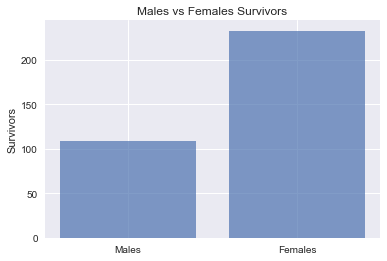

In [16]:
# GRAPH the number of males and females who SURVIVED

objects = ('Males', 'Females')
y_pos = np.arange(len(objects))
performance = [s_males, s_females]
plt.bar(y_pos, performance, align='center', alpha=0.7)
plt.xticks(y_pos, objects)
plt.ylabel('Survivors')
plt.title('Males vs Females Survivors')

In [17]:
# COUNT the number of males and females who PERISHED (pandas series.)
perished = 0
p_males, p_females = males_vs_females(titanic_df, perished)
print ("Males: ", p_males, "Females: ", p_females)

# NOTICE: There were more than 5.5X the number of males that perished compared to females.

Males:  468 Females:  81


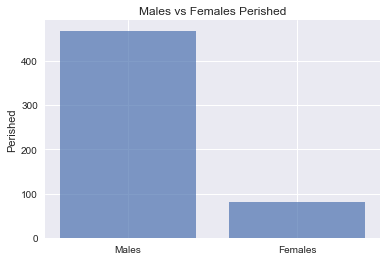

In [18]:
# GRAPH the number of males and females who PERISHED 

objects = ('Males', 'Females')
y_pos = np.arange(len(objects))
performance = [p_males, p_females]
plt.bar(y_pos, performance, align='center', alpha=0.7)
plt.xticks(y_pos, objects)
plt.ylabel('Perished')
plt.title('Males vs Females Perished')

>  

**Conclusions of First Line of Investigation: **  

Interrogating the data has shown us:


* There were more than **twice** as many females as males represented in those who **survived**. **[Females: 233, Males: 109]**
* A "rough estimate" is that there were more than **five and a half** times as many males who **perished** than females. **[Males: 468 Females: 81]**

Therefore **reasonable to suspect** that the cultural imperative (Chivalry) of the time period **contributed significantly** as a factor in the survival rates.


**However** - Although "Chivalry" is a major contributing factor in the survival rates, it is **not** the only one. There are more, and those will be the focus of the **next line of inquiry**.


>  



**Second Line of Inquiry: Social Class and Survival on the Titanic**


Wayne Hall from the Department of Psychiatry and Behavioural Science, The University of Western Australia, Nedlands, W.A.
6009, Australia writes about the relationship between ** Social Status and Survival Rates** in a research study which concluded:


> Passengers’ chances of surviving the sinking of the S.S. Titanic were **related to
their sex and their social class: females were more likely to survive than males,
and the chances of survival declined with social class** as measured by the class
in which the passenger travelled. The probable reasons for these differences in
rates of survival are discussed, as are the reasons accepted, by the **Mersey
Committee of Inquiry** into the sinking.


* Source: http://api.rue89.nouvelobs.com/sites/news/files/assets/document/2012/04/hallssm2261986.pdf

>  


**Key Question: ** To what extend did social status (class) impact the survival rates?

>  


** REQUIREMENT: ** Two new Tools for efficient (a) **hypothesis testing**, and for (b) **measuring accuracy** of the heuristics implementing new theories.

>  What is constructed below is a simple **(a) heuristic function** to predict the survival rate for a given hypothesis and a **(b) scoring function** to determine the accuracy of those predictions against the "Survived" column of the dataframe.



** FUNCTIONS**

In [19]:
# Heuristic Implementation for *FEMALE ONLY* contributions to survival rates.
# This small function gets executed via a Pandas DF MAP function for fast vectorized
# calculations so it doesn't have to do much more than a quick compate and return.
# Returns 0 or 1 depending on if 'female' or not.

import numpy
import pandas
import statsmodels.api as sm  
    
def female_only_heuristic(cell):
    if cell == 'female':
        return 1
    else:
        return 0

    
# SCORING ALGORITHM for measuring accuracy of various Heuristics against the SURVIVED Column in the DataFrame.
# This ingests TWO separate Pandas "Series" and does a case by case comparison of the predicted vs actual to
# derive an overall score, and remadial stats.
# The tallys for correct, incorrect, index and accuracy are then returned.

from __future__ import division
    
def score_heuristic(predicted, actual):
    correct = (predicted == actual).sum()
    incorrect = (predicted != actual).sum()
    total = len(actual)
    return correct, incorrect, total, correct / total

/Users/chamling/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [20]:
# Use vector operations of Pandas DataFrame for fast mapping of simple heuristic fuction
# Capture resulting Pandas Series for later interrogation.

female_only_heuristic_predictions = titanic_df['Sex'].map(female_only_heuristic)

** CALCULATIONS**

In [21]:
# Score the survival reate predictions of the given heuristic results against the 
# actual SURVIVED column of the dataframe.

fo_correct, fo_incorrect, index, fo_accuracy = score_heuristic(female_only_heuristic_predictions, titanic_df['Survived'])
print ("Correct: ", fo_correct, "Incorrect: ", fo_incorrect, "Index: ", index, "Accuracy: ", fo_accuracy)

Correct:  701 Incorrect:  190 Index:  891 Accuracy:  0.786756453423



**ANALYSIS** - the contribution of ONLY **gender = 'female'** as a predictor to the survival rate is **very significant** at 78.67 % accuracy.

This is a good secondary check to the validity of our first line of inquiry.


**Next**, the contributions for the **Social Status (or Class)** will be investigated re-using the above tools.


** FUNCTIONS**

In [22]:
# Heuristic Implementation for *SOCIAL STATUS ONLY* contributions to survival rates.
# This small function gets executed via a Pandas DF MAP function for fast vectorized
# calculations so it doesn't have to do much more than a quick compate and return.
# Returns 0 or 1 depending on if 'pclass' eq 1 or 2.

import numpy
import pandas
import statsmodels.api as sm

def class_only_heuristic(pclass):
    if (pclass == 1) or (pclass ==2):
        return 1
    else:
        return 0

** CALCULATIONS**

In [23]:
# Use vector operations of Pandas DataFrame for fast mapping of simple heuristic fuction
# Capture resulting Pandas Series for later interrogation.

class_only_heuristic_predictions = titanic_df['Pclass'].map(class_only_heuristic)

In [24]:
# Score the survival reate predictions of the given heuristic results against the 
# actual SURVIVED column of the dataframe.

co_correct, co_incorrect, index, co_accuracy = score_heuristic(class_only_heuristic_predictions, titanic_df['Survived'])
print ("Correct: ", co_correct, "Incorrect: ", co_incorrect, "Index: ", index, "Accuracy: ", co_accuracy)

Correct:  595 Incorrect:  296 Index:  891 Accuracy:  0.667789001122



**ANALYSIS** - the contribution of Class ONLY **(Pclass = 1 or 2)** as a predictor to the survival rate is ** significant** at 66.77 % accuracy.

This supports that argument that Social Status (as Pclass) is also significant contributor to survival rates.


>  **Next**, the **isolation of contributing factors** can only be so helpful, the various factors **must be considered in combination** with each other for a composite score along with **"other"** contributing factors to establish more accurate predictive capabilities.


** FUNCTIONS**

In [25]:
# Heuristic Implementation for *COMBINATIONS* of contributions to survival rates.
# Ingests a dataframe, constructs a predictions dictionary, and then populates it with 
# the survival predictions (both lived and perished) as calculated from the heuristic.

import numpy
import pandas
import statsmodels.api as sm
    
def combination_heuristic(sex, pclass, age):
    if ( (sex == 'female') or
             (pclass == 1 and age <18 ) or
             (pclass == 2 and age <18 ) or
             (age < 1 and pclass == 3)
            ):
        return 1
    else:
        return 0    

In [26]:
# Use vector operations of Pandas DataFrame for fast mapping of simple heuristic fuction
# Capture resulting Pandas Series for later interrogation. Since there are multiple columns 
# needing to be passed in, pass a lambda which unpacks the Series into separate arguments

combination_heuristic_predictions = titanic_df[['Sex', 'Pclass', 'Age']].apply(lambda x: combination_heuristic(*x), axis=1)

In [27]:
# Score the survival reate predictions of the given heuristic results against the 
# actual SURVIVED column of the dataframe.

cmb_correct, cmb_incorrect, index, cmb_accuracy = score_heuristic(combination_heuristic_predictions, titanic_df['Survived'])
print ("Correct: ", cmb_correct, "Incorrect: ", cmb_incorrect, "Index: ", index, "Accuracy: ", cmb_accuracy)

Correct:  713 Incorrect:  178 Index:  891 Accuracy:  0.800224466891


** CALCULATIONS**

** ANALYSIS ** - Combinations of factors contributing to enhanced prediction accuracy. 

After lengthy contemplations and much experimentation with the combinations of factors, the following combination was arrived at which **achieved a level of predictive accuracy of 80% **.

Each factor is given along with a commentary of why it might have contributed:

* **Sex: Female** - this was the single most contributing factor toward survival. If one was female, they stood the best chance of survival.
* **Pclass: 1 or 2 **- class was very significant in determining survival rates. The accuracy of the predictive powers of class were enhanced significantly when **Age** was combined. It seemed that **anyone under 18 who was in first or second class has a far better chance of survival**. 
* **Age and PClass** - Specifically **those under 1 years of age in 3rd class** stood a decent chance of survival. It would appear that the infants in 3rd class were given elevated priority. 

>   

NOTE: **Some combinations had negative consequences** toward predictive accuracy, those were avoided.

>  

**Next** - Heuristics alone are **not sufficient** to uncover many of the **"non-obvious"** underlying combinations that are still significant contributors. In an attempt to find those we need to leverage a process from **Machine Learning** called **Feature Engineering**. To do this, we'll use a completely different dataframe (titanic_ml_df) on which to experiment on, leaving the original dataframe (titanic_df) in it's pure form. Any transformations of interest done on the "titanic_ml_df" will need to be manually injected into the "titanic_df" in the final heuristic.

>  Note: Feature Engineering requires some **dataframe transformations** and the creation of some completely **new features**.


** MACHINE LEARNING DATAFRAME TRANSFORMATIONS**

> The process of **feature engineering** requires transformations be done on existing columns in the dataframe. In the interest of maintaining purity of the original dataframes, it is recommended to use a completely different dataframe for this experimental process and then **inject the results back into the heuristic** construction. The necessary transformation are listed below:

* **AGE** - Age has some missing values and/or NaN's which need to be addressed.
* **SEX** - Sex has non-numeric values which need to be converted.
* **EMBARKED** - Embarked also has non-numeric values which require conversion.


In [28]:
# Read the data into a NEW dataframe for this process.
filename = 'titanic_data.csv'
titanic_ml_df = pd.read_csv(filename)

In [29]:
# Examine out the summary statistics of the dataframe for any obvious concerns
titanic_ml_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [30]:
# Examine the data of dataframe for any obvious concerns

titanic_ml_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


**OBSERVATIONS / AREAS OF CONCERN**


**AGE**

>  The **AGE column** (above) the **count row** is **714** while the rest are 891. This indicates the presence of **missing values**, nulls, or NaN's.


** SEX**

>  The **SEX** Column needs to be transformed to a numeric field for Machine Learning Algorithms to operate on it.

**EMBARKED**

>  The **Embarked** column also needs to be transformed to a **dummy fields** for each port, and some NA's filled with 'S' so tha the Machine Learning Algorithms can operate on it.

** MACHINE LEARNING DATAFRAME TRANSFORMATIONS CODE**

In [31]:
# MACHINE LEARNING DATAFRAME TRANSFORMATIONS

# AGE - this column has missing values which we'll simply substitute the median values of the column for each one.
titanic_ml_df["Age"] = titanic_ml_df["Age"].fillna(titanic_ml_df["Age"].median())

# SEX - transform from a string to numeric
titanic_ml_df.loc[titanic_ml_df["Sex"] == "male", "Sex"] = 0 
titanic_ml_df.loc[titanic_ml_df["Sex"] == "female", "Sex"] = 1

# EMBARKED - transform from a string to numeric
titanic_ml_df["Embarked"] = titanic_ml_df["Embarked"].fillna("S")

# NOTE: Categorical Variables "Embarked" cannot be represented as continuous:
#       To fix this we create "dummy" variables where each category 
#       is given its own column and the values are 0 and 1 to indicate 
#       if the corresponding row is that category or not. Returns a dataframe.
dummies = pd.get_dummies(titanic_ml_df['Embarked'])

# Concatinate the "dummies" dataframe to the "titanic_ml_df" for further use.
titanic_ml_df = pd.concat([titanic_ml_df, dummies], axis=1)

In [32]:
# Verify that the Transformations worked as expected (NEW Columns C, Q, and S).
titanic_ml_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,0,1


** GENERATING NEW FEATURES**

There are some new features which could be generated that have the potential to add value to the accuracy of the predictive powers of the heuristic. The following are those:

* **Length of the Name**  - could indicate how **wealthy** the person was and thus their **social standing** on the ship.
* **Family Size** - defined as (SibSp + Parch),  larger or smaller families **might have preference**.
* **Titles** - were generally an indication of **elevated social standing** such as: ( "Major", "Col", "Mlle" "Don", "Lady", "Countess", etc).
 

In [33]:
# NEW FEATURE GENERATION

# FAMILY SIZE
# Generating a NEW FamilySize column by adding the columns "SibSp" and "Parch"
titanic_ml_df["FamilySize"] = titanic_ml_df["SibSp"] + titanic_ml_df["Parch"]


# NAME LENGTH :=> Leverage '.apply method'
# Use the '.apply method' to generate a NEW column "NameLength" by taking the length of the NAME column
#
titanic_ml_df["NameLength"] = titanic_ml_df["Name"].apply(lambda x: len(x))



# TITLES
# Extract the passengers TITLE from their name and create a NEW column "TITLE"

# Function 'get-title' leveraging "regular expressions".
# Returns the title or nothing if there is none.
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""


# :=> Leverage '.apply method' to fetch all of the titles from the NAME column
titles = titanic_ml_df["Name"].apply(get_title)


# Create a numerical mapping for each extracted title of interest
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, 
                 "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, 
                 "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}

# Create the Titles Series.
for abreviation, value in title_mapping.items():
    titles[titles == abreviation] = value

# Add in the NEW Title column.
titanic_ml_df["Title"] = titles


In [34]:
# Verify that the New Features worked as expected. 
titanic_ml_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,C,Q,S,FamilySize,NameLength,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,1,23,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,1,51,3
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,0,22,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,0,0,1,1,44,3
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,24,1


** FINDING THE BEST FEATURES**

>  **Machine Learning** adds value to the quest to obtain more accuracy from our heuristic. One way to do this is to use the **univariate feature selection** from **Scikit-Learn**. This process (effectively) traverses each column and determines **which columns correlate most closely with what is attempting to predict** ['Survived']. **Scikit-Learn** has a function to make this process easier **SelectKBest**, which slects the best feature(s) from the data.


**STATISTICAL RIGOR UNDER THE HOOD**

>  The beauty of Scikit-Learn SelectKBest function is that it leverages all of the **important statistical tests** to ensure rigor in the determination process, specifically **ANOVA with F-values and P-values**.


* Source: http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html
* Source: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
* Source: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


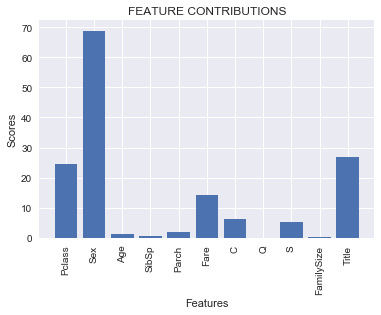

In [35]:
# FINDING THE BEST FEATURE and PLOT them.

import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

# Establish Predictors
# predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "Title"]
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "C", "Q", "S", "FamilySize", "Title"]

# Perform feature selection using ANOVA F-value between labe/feature for classification tasks,
# and get the appropriate features.
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic_ml_df[predictors], titanic_ml_df["Survived"])

# Fetch the raw p-values for each feature, and transform from p-values into scores
# using Numpy's Log10 function.

# NOTE: The "-np.log10" is used to ensure the normalization of the input variables (selector.pvalues_),
#       that the input variables are approximately normal in distribution, and that the output variable 
#       is constant variance (that the variance of the output variable is independent of the input variables).
#       Without this transformation the scores would not produce the results we desire (best feature).
scores = -np.log10(selector.pvalues_)

# Plot the scores, and NOTICE: the larger contribution of "Pclass", "Sex", "Title", and "Fare".
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Scores')
plt.title('FEATURE CONTRIBUTIONS')
plt.show()

**ANALYSIS**

>  Using Machine Learning techniques and leveraging its inherent statistical rigor, it was determined that the following features provided the most significant contributions to survival rate prediction:


* "Pclass"
* "Sex"
* "Title"
* "Fare"
* "C" = Embarked at Cherbourg


**Using Machine Learning for Scoring Thresholds**

**WHY?** - Accuracy for Linear Regression techniques degrades if the data is non-linear in nature, which this dataset is. In order to achieve more accurate predictive capabilities, a non-linear approach is required, such as **Random Forests**.

>  Machine Learning can provide enhanced accuracy levels for predictions. **Scikit-Learn** has a classifier called **"RandomForestClassifier"** which is more accurate. Using this to generate prediction accuracy levels establishes a threshold to aim for when it comes to improving the accuracy of the heuristics.



In [36]:
# MACHINE LEARNING -> RANDOM_FORREST_CLASSIFIER 

# Pick only the four best features - manually.
predictors = ["Pclass", "Sex", "Fare", "Title", "C"]

# Use a forrest of 150 trees (avoid Over Fitting), split nodes at 8 samples, all nodes must have 4 leaves.
algorithm = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

# Compute the accuracy score for all the forrests (cross validation folds)
accuracy_scores = cross_validation.cross_val_score(algorithm, titanic_ml_df[predictors], titanic_ml_df["Survived"], cv=3)

# Take the mean of the scores
print ("RandomForestClassifier Accuracy: " ,(accuracy_scores.mean()))

RandomForestClassifier Accuracy:  0.820426487093


**MACHINE LEARNING ANALYSIS**

> The **RandomForestClassifier** algorithm from the Scikit-Learn library is able to take the four best predictors **["Pclass", "Sex", "Fare", "Title"]**, and generate a predictive measure of roughly **82.04** %. There is still room for improvement, but it does provide a reasonable goal to aim for from the heuristics, and a validation that they are performing well. The **next task** is to **inject the results of this experiment into the advanced heuristic**.

**ADVANCED HEURISTIC injected with Machine Learning Enhancements**

**Injecting the Machine Learning Results into the Heuristic**

>  The feature selection and accuracy thresholds from the Machine Learning process add value when injected into the hueristic. It's easier to see it in action when it's combined into an complete function.


In [37]:
#  ADVANCED HEURISTIC injected with Machine Learning Enhancements 

# Setup the various IMPORT statements for required libraries

from IPython.display import Image
import csv
import re
import operator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from __future__ import division  # forces "/ "to adopt Python 3.x's behavior that always returns a float.

# Inline Graphics for IPython NB's
# %pylab inline


def advanced_heuristic(filename):   

    # Containers to hold the heuristic contributions for plotting purposes.
    #
    contributions = {}   # Feature Contributions Dictionary
                         # Individual Contribututors:
    category_1 = 0       # Female 
    category_2 = 0       # 1stC <18
    category_3 = 0       # 2ndC <18
    category_4 = 0       # TC Infant
    category_5 = 0       # Long Name (status)
    category_6 = 0       # Title: Female Indicative
    category_7 = 0       # Male under 15 of small familySize < 3
    category_8 = 0       # Male, Title:(Master, Miss, Missis), 3rd Class, SibSp (number of siblings) <= 2
    
    # Create Predictions Dictionary & Read in the data into a DF
    predictions = {}
    titanic = pd.read_csv(filename)
    
    # FAMILY SIZE
    # Generating a NEW FamilySize column by adding teh columns "SibSp" and "Parch"
    titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]


    # NAME LENGTH
    # Use the '.apply method' to generate a NEW column "NameLength" by taking the length of the NAME column
    titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))


    # TITLES
    # Extract the passengers TITLE from their name and create a NEW column "TITLE"

    # Function 'get-title'
    # Returns the title or nothing if there is none.
    def get_title(name):
        title_search = re.search(' ([A-Za-z]+)\.', name)
        if title_search:
            return title_search.group(1)
        return ""

    # Use the '.apply method' to fetch all of the titles from the NAME column
    titles = titanic["Name"].apply(get_title)

    # Create a numerical mapping for each extracted title of interest
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, 
                     "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, 
                     "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}

    # Create the Titles Series.
    for abreviation, value in title_mapping.items():
        titles[titles == abreviation] = value

    # Add in the NEW Title column.
    titanic["Title"] = titles      
    
    
    # Heuristic Implementation 
    # Function applied as a vector operation of a Pandas Dataframe for fast execution.
    # Ingests multiple Pandas Series and does a quick comparison returning a prediction of 
    # 0 or 1.
    #
    def heuristic(sex, pclass, age, namelength, title, familysize, sibsp):
        if ( 
             (sex == 'female')                   # Female
              or (pclass == 1 and age <19)       # 1stC <18
              or (pclass == 2 and age <18)       # 2ndC <18
              or (age < 1 and pclass == 3)       # TC Infant
              or (namelength > 40)               # Long Name (status)
              or (title == 2 or title == 8)      # Title: Female Indicative
              or (sex == 'male' and age < 15 and familysize <3 ) # Male under 15 of small familySize < 3
              # Male, Title:(master, Miss, Missis), 3rd Class, SibSp (number of siblings) <= 2
              or (sex == 'male' and (title == 4 or title == 2) and pclass == 3 and sibsp <= 2)            
            ):
            return 1
        else:
            return 0      
    

    # Use vector operations of Pandas DataFrame for fast mapping of simple heuristic fuction
    # Capture resulting Pandas Series for later interrogation. Since there are multiple columns 
    # needing to be passed in, pass a lambda which unpacks the Series into separate arguments    
    predictions = titanic[['Sex', 'Pclass', 'Age', 'NameLength', 'Title', 'FamilySize', 'SibSp']].apply(lambda x: heuristic(*x), axis=1)
       
    
    # Gather Simple Statistical Contribution Data for plots.
    #
    for passenger_index, passenger in titanic.iterrows():
        # Capture simple Contrbution Data for PLOTTING purposes.
        if passenger['Sex'] == 'female':
            category_1 +=1
        if (passenger['Pclass'] == 1 and passenger['Age'] <19):
            category_2 +=1
        if (passenger['Pclass'] == 2 and passenger['Age'] <18):
            category_3 +=1
        if (passenger['Age'] < 1 and passenger['Pclass'] == 3):
            category_4 +=1
        if (passenger['NameLength'] > 40):
            category_5 +=1
        if (passenger["Title"] == 2 or passenger["Title"] == 8):
            category_6 +=1
        if (passenger['Sex'] == 'male' and passenger['Age'] < 15 and passenger['FamilySize'] <3 ):
            category_7 +=1
        if (passenger['Sex'] == 'male' and (passenger["Title"] == 4 or passenger["Title"] == 2) 
                                       and passenger['Pclass'] == 3 and passenger['SibSp'] <= 2):
            category_8 +=1        
        
    # Append contributions to a dictionary:    
    contributions.update({'category_1': category_1, 'category_2': category_2, 'category_3': category_3, 
                          'category_4': category_4, 'category_5': category_5, 'category_6': category_6,
                          'category_7': category_7, 'category_8': category_8,})          

        
    return predictions, contributions


In [38]:
# Compute the survival rate predictions for the ADVANCED HEURISTIC

advanced_heuristic_predictions, advanced_heuristic_contributions = advanced_heuristic(filename)

In [39]:
# Score the survival reate predictions of the given heuristic results against the 
# actual SURVIVED column of the dataframe.

adv_correct, adv_incorrect, index, adv_accuracy = score_heuristic(advanced_heuristic_predictions, titanic_df['Survived'])
print ("Correct: ", adv_correct, "Incorrect: ", adv_incorrect, "Index: ", index, "Accuracy: ", adv_accuracy)

Correct:  722 Incorrect:  169 Index:  891 Accuracy:  0.810325476992


**ANALYSIS**

**Commentary on combinations of features contributing to enhanced accuracy **

After lengthy contemplations and much experimentation with the combinations of factors, the following combination(s) were arrived at which achieved a level of predictive accuracy greater than **81 % ** .

Each factor is given along with a commentary of why it might have contributed:

>   **TITLE** - Female indicative: ("Miss", "Ms", "Mlle", "Mme"). Any indication a person was a **female** enhanced the survival rate. 

>   **MALES** - (under 15 of families < 3). Males under 15 and of small families (probably the only child to carry on the family name) improved the odds of survival.

>   **UNIQUE COMBINATION** - Male, Title:("Master", "Miss", "Ms"), 3rd Class, SibSp (number of siblings) <= 2. Some unique combinations did indeed contribute, but these were hardly intuitive.



** PIE CHART - Breakdown of Feature Contributions**

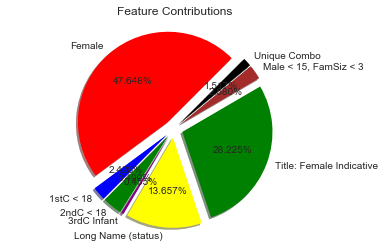

In [40]:
# PIE CHART - Breakdown of Feature Contributions

# category_1       # Female 
# category_2       # 1stC < 18
# category_3       # 2ndC < 18
# category_4       # 3rdC Infant
# category_5       # Long Name (status)
# category_6       # Title: Female Indicative
# category_7       # Male under 15 of small familySize < 3
# category_8       # Male, Title:(master, Miss, Missis), 3rd Class, SibSp (number of siblings) <= 2


category_1 = advanced_heuristic_contributions['category_1']
category_2 = advanced_heuristic_contributions['category_2']
category_3 = advanced_heuristic_contributions['category_3']
category_4 = advanced_heuristic_contributions['category_4']
category_5 = advanced_heuristic_contributions['category_5']
category_6 = advanced_heuristic_contributions['category_6']
category_7 = advanced_heuristic_contributions['category_7']
category_8 = advanced_heuristic_contributions['category_8']

# GRAPH - Feature Contributions
labels = 'Female', '1stC < 18', '2ndC < 18', '3rdC Infant', 'Long Name (status)', 'Title: Female Indicative', 'Male < 15, FamSiz < 3', 'Unique Combo'
contributions = [category_1, category_2, category_3, category_4, category_5, category_6, category_7, category_8]
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'green', 'brown', 'black' ]
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # explode each slice

plt.pie(contributions, explode=explode, labels=labels, colors=colors, autopct='%1.3f%%', shadow=True, startangle=45)
plt.axis('equal')
plt.title('Feature Contributions')


plt.show()

** BAR CHART - Breakdown of Feature Contributions**

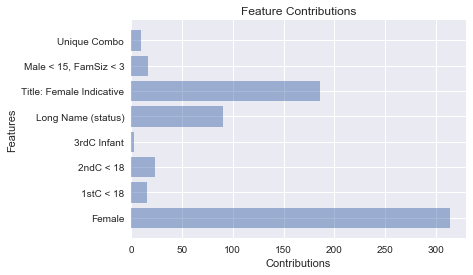

In [41]:
# BAR CHART - Breakdown of Feature Contributions
objects = ('Female', '1stC < 18', '2ndC < 18', '3rdC Infant', 'Long Name (status)', 'Title: Female Indicative', 'Male < 15, FamSiz < 3', 'Unique Combo')
y_pos = np.arange(len(objects))
performance = [category_1, category_2, category_3, category_4, category_5, category_6, category_7, category_8]
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Contributions')
plt.ylabel('Features')
plt.title('Feature Contributions')
plt.show()

** FINDINGS & CONCLUSIONS**


* **KEY QUESTION: "What factors made people more likely to survive?"**

>  

**(1) Initial Line of Inquiry:**

>  Did the **"Chivalry"** and the **"Women and Children First"** cultural imperative of the time period manifest itself in the data as it would be expected to?

**ANALYSIS** - Interrogating the data has shown us:

* There were more than **twice** as many females as males represented in those who **survived**. **[Males: 109 Females: 233]**
* There were more that **five and a half** times as many males who **perished** than females. **[Males: 468 Females: 81]**

Therefore **reasonable to infer ** that the cultural imperative (Chivalry) of the time period **contributed significantly** as a factor in the survival rates at **78.67 %** accuracy.

>  

**(2) Second Line of Inquiry:**

>  Were the passengers chances of surviving the disaster related to their **gender and their social class**  as measured by the class in which the passenger traveled.  

**ANALYSIS** - the contribution of Class ONLY **(Pclass = 1 or 2)** as an independent predictor to the survival rate is **significant** at **66.77 %** accuracy, which supports the argument that **social status played a significant role** in survival rates.


>  


**(3) Third Line of Inquiry:**

>   Were there unique (and occasionally non-intuitive) **combinations of features** contributing to survival rates?


**ANALYSIS** - The consideration of contributing factors in **isolation** is **not** sufficient to achieve more accurate prediction / understanding of survival rates, those factors need to be **considered in concert** with each other to better understand the total picture. 

The following contributing factors were **considered in concert** with each achieving a level of predictive accuracy at the ** 80 % ** range:

* **Sex: Female** - this was the single most contributing factor toward survival. If one was female, they stood the best chance of survival.
* **Pclass: 1 or 2 **- class was very significant in determining survival rates. The accuracy of the predictive powers of class were enhanced significantly when **Age** was combined. It seemed that **anyone under 18 who was in first or second class has a far better chance of survival**. 
* **Age and PClass** - Specifically **those under 1 years of age in 3rd class** stood a decent chance of survival. It would appear that the infants in 3rd class were given elevated priority. 

>  
  

**(4) Forth Line of Inquiry:**

>  Are there contributions from **Machine Learning** which could improve predictive accuracy? What is the net result of those contributions?

**ANALYSIS** - Machine Learning Algorithms are able to discern (unique) combinations of features in concert with each other that provide more accurate predictions. The two aspects chosen to assist in this study were: 

* **(A) Feature Engineering** - The **univariate feature selection** from **Scikit-Learn** using the **SelectKBest**, slects the **best feature(s)** from the data, and given this dataset recommended the features: **["Pclass", "Sex", "Fare", "Title"]** as contributing the most to predictive accuracy.


* **(B) Machine Learning Accuracy Enhancements** - The **RandomForestClassifier** algorithm from the **Scikit-Learn** library is able to take the four best predictors **["Pclass", "Sex", "Fare", "Title"]**, and generate a predictive measure in excess of **81.2 %**. There is still room for improvement, but it does provide a reasonable goal to aim for from the heuristics, and a validation that they are performing well.

>  

** Fifth Line of Inquiry:**

>  Will injecting Machine Learning enhancements into the heuristic improve accuracy?

**ANALYSIS** - Upon injecting the products of the Machine Learning Experiment into the Heuristic the following combination(s) were arrived at which achieved a level of predictive accuracy slightly greater than **81 % **. Those **injected features** were:

>   **TITLE** - Female indicative: ("Miss", "Ms", "Mlle", "Mme"). Any indication a person was a female aided in the survival rate. 

>   **MALES** - (under 15 of families < 3). Males uder 15 and of small families (probably the only child to carry on the family name) improved the odds of survival.

>   **UNIQUE COMBINATION** - Male, Title:("Master", "Miss", "Ms"), 3rd Class, SibSp (number of siblings) <= 2. Some unique combinations did indeed proved significant, but hardly intuitive.

>  

** CONCLUSION: Feature Composition of the Advanced Heuristic**

> The following is the final composition of features comprising the Advanced Heuristic and an answer to the question of **"What factors made people more likely to survive".** 

**Those factors were:**

* Female Gender
* 1st Class Passenger under the age of 18
* 2nd Class Passenger under the age of 18
* Third Class Infant of one year or younger.
* Long Name (As Indicator of Social Status and therefore Travel Class.)
* Title: Anything Female Indicative (Miss, Mrs, etc ....)
* Male under 15 of small familySize < 3 - Probably the only Male to continue the family name.
* Unique (non intuitive) Combination: Male, Title:(Master, Miss, Missis), 3rd Class, SibSp (number of siblings) <= 2
    

>  
>



** LIMITATIONS AND SHORTCOMINGS **

> Some of the most obvious limitations are:
* Small and incomplete data set
* Relative unsophisticated heuristics algorithm
* Lack of Dominant features for the last 20% of accuracy
* Machine Learning Sophistication (Decision Trees)

> The **small and incomplete data set**  is really the biggest limitation of this study. It's difficult to ferret out all of the features possible in route to developing a more accurate heuristic when the data is not a rich as it could be. This contributes to a **relatively unsophisticated heuristics algorithm**. Although the heuritsics algorithm is a product of intitution and an injection of Machine Leanning discoveries (feature engineering), it could be better, particularly in the last 15 - 18% accuracy (post 81%). Since there is a **lack of a dominant feature for that last percentage of accuracy**, it's difficult to make progress past 81% or so. Finally, the promise of accuracy advancements from **Machine Learning Decision Trees** was not taken as far as possible and could be improved.  



**REFERENCES**


Event Background:
https://en.wikipedia.org/wiki/RMS_Titanic

Passengers Information:
https://en.wikipedia.org/wiki/Passengers_of_the_RMS_Titanic

1912 chivalry vs 2012 Cowardice:
http://www.reddirtreport.com/dust-devil-dreams/1912-chivalry-vs-2012-cowardice

The Costa Concordia, The Titanic, and Cowardice at Sea:
http://blogs.wsj.com/speakeasy/2012/01/23/the-costa-concordia-the-titanic-and-cowardice-at-sea/

Social Class and Survival on the Titanic:
http://api.rue89.nouvelobs.com/sites/news/files/assets/document/2012/04/hallssm2261986.pdf

Titanic: Machine Learning from Disaster:
https://www.kaggle.com/c/titanic

Data Repository:
https://www.kaggle.com/c/titanic/data

Part One:
https://www.dataquest.io/mission/74/getting-started-with-kaggle

Part Two:
https://www.dataquest.io/mission/75/improving-your-submission

Titanic's Band:
https://en.wikipedia.org/wiki/Legends_and_myths_regarding_RMS_Titanic

Sicikit-Learn:
http://scikit-learn.org/stable/

Univariate Feature Selection:
http://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html

SelectKBest:
http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

RandomForestClassifier:
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

MatPlotLib:
https://pythonspot.com/matplotlib-bar-chart/


